In [1]:
import os
import sys
import glob

sys.path.append(os.getcwd())

import torch
from lossless.component.coolchic import CoolChicEncoderParameter
from lossless.component.frame import load_frame_encoder
from lossless.component.types import NAME_COOLCHIC_ENC
from lossless.component.image import (
    FrameEncoderManager,
    encode_one_frame,
)
from enc.utils.codingstructure import CodingStructure, Frame
from typing import Any, Dict, List
from lossless.component.coolchic import CoolChicEncoder
from torchac import torchac
import numpy as np
import cv2
import matplotlib.pyplot as plt

from lossless.util.config import (
    DATASET_PATH,
    TEST_WORKDIR,
    PATH_COOL_CHIC_CFG,
    IMAGE_PATHS,
    args,
    start_print
)
from lossless.util.print_formatting import pretty_str_dict
from lossless.util.parsecli import change_n_out_synth, get_coolchic_param_from_args, get_manager_from_args
from lossless.util.misc import clean_workdir
from lossless.training.train import train
from lossless.util.encoding import encode, decode

print(IMAGE_PATHS)
print(pretty_str_dict(args))
print("----------")
print(start_print)

frame_encoder_manager = FrameEncoderManager(**get_manager_from_args(args))

Using /home/jakub/.cache/torch_extensions/py310_cu126 as PyTorch extensions root...
Emitting ninja build file /home/jakub/.cache/torch_extensions/py310_cu126/torchac_backend/build.ninja...
Building extension module torchac_backend...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
Loading extension module torchac_backend...


ninja: no work to do.
['/home/jakub/ETH/2025_2026_fall/thesis/Cool-Chic/coolchic/../datasets/kodak/kodim01.png', '/home/jakub/ETH/2025_2026_fall/thesis/Cool-Chic/coolchic/../datasets/kodak/kodim02.png', '/home/jakub/ETH/2025_2026_fall/thesis/Cool-Chic/coolchic/../datasets/kodak/kodim03.png', '/home/jakub/ETH/2025_2026_fall/thesis/Cool-Chic/coolchic/../datasets/kodak/kodim04.png', '/home/jakub/ETH/2025_2026_fall/thesis/Cool-Chic/coolchic/../datasets/kodak/kodim05.png', '/home/jakub/ETH/2025_2026_fall/thesis/Cool-Chic/coolchic/../datasets/kodak/kodim06.png', '/home/jakub/ETH/2025_2026_fall/thesis/Cool-Chic/coolchic/../datasets/kodak/kodim07.png', '/home/jakub/ETH/2025_2026_fall/thesis/Cool-Chic/coolchic/../datasets/kodak/kodim08.png', '/home/jakub/ETH/2025_2026_fall/thesis/Cool-Chic/coolchic/../datasets/kodak/kodim09.png', '/home/jakub/ETH/2025_2026_fall/thesis/Cool-Chic/coolchic/../datasets/kodak/kodim10.png', '/home/jakub/ETH/2025_2026_fall/thesis/Cool-Chic/coolchic/../datasets/kodak/k

In [2]:
clean_workdir(args["workdir"])

Removing /home/jakub/ETH/2025_2026_fall/thesis/Cool-Chic/coolchic/test-workdir/...


/home/jakub/ETH/2025_2026_fall/thesis/Cool-Chic/coolchic/../datasets/kodak/kodim01.png


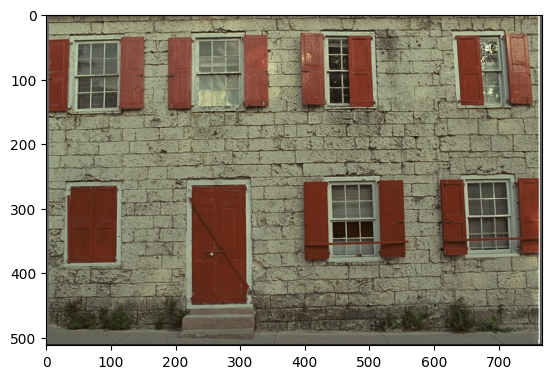

torch.Size([1, 3, 512, 768])


In [3]:
print(args["input"])
im = cv2.imread(filename=args["input"])
assert im is not None, f"Failed to read image {args['input']}"
im = im[:, :, ::-1]  # Convert BGR to RGB
plt.imshow(im)
plt.show()

im = im.transpose(2, 0, 1)[None,]  # Change to CxHxW
im_tensor = torch.from_numpy(im.copy()).float() / 255.0  # Normalize to [0, 1]
print(im_tensor.shape)
im_tensor = im_tensor.to("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
encoder_param = CoolChicEncoderParameter(
    **get_coolchic_param_from_args(args, "residue")
)
encoder_param.set_image_size((512, 768))
encoder_param.layers_synthesis = change_n_out_synth(
    encoder_param.layers_synthesis, 6
)

coolchic = CoolChicEncoder(param=encoder_param)
coolchic.to_device("cuda:0")
# coolchic.eval()

# for i, grid in enumerate(coolchic.latent_grids):
#     # Instead of default initialization, use larger values
#     grid.data.normal_(0.2, 0.5)  # Mean=0, std=0.5 instead of very small values
#     print(f"   Reinitialized Grid {i}: mean={grid.data.mean():.4f}, std={grid.data.std():.4f}")

# print(coolchic.pretty_string(True))


In [5]:
model = train(
    model=coolchic,
    target_image=im_tensor,
    frame_encoder_manager=frame_encoder_manager,
    start_lr=args["start_lr"],
    lmbda=args["lmbda"],
    cosine_scheduling_lr=args["schedule_lr"],
    max_iterations=args["n_itr"],
    frequency_validation=args["freq_valid"],
    patience=args["patience"],
    optimized_module=args["optimized_module"],
    quantizer_type=args["quantizer_type"],
    quantizer_noise_type=args["quantizer_noise_type"],
    softround_temperature=args["softround_temperature"],
    noise_parameter=args["noise_parameter"],
    loss_latent_multiplier=1.0,
)

new rate is: 6.918671607971191, old rate is: 9.004538536071777
delta loss: 2.085866928100586, flag new record: True
Found new best model!
Iteration: 100, Loss: 6.9187, Rate NN: 0.0000, Rate Latent: 0.0512, Rate Img: 6.8674
new rate is: 6.487434387207031, old rate is: 6.918671607971191
delta loss: 0.43123722076416016, flag new record: True
Found new best model!
Iteration: 200, Loss: 6.4874, Rate NN: 0.0000, Rate Latent: 0.1466, Rate Img: 6.3408
new rate is: 6.118190765380859, old rate is: 6.487434387207031
delta loss: 0.3692436218261719, flag new record: True
Found new best model!
Iteration: 300, Loss: 6.1182, Rate NN: 0.0000, Rate Latent: 0.1816, Rate Img: 5.9366
new rate is: 6.007485866546631, old rate is: 6.118190765380859
delta loss: 0.11070489883422852, flag new record: True
Found new best model!
Iteration: 400, Loss: 6.0075, Rate NN: 0.0000, Rate Latent: 0.2040, Rate Img: 5.8035
new rate is: 5.912286758422852, old rate is: 6.007485866546631
delta loss: 0.0951991081237793, flag new

In [6]:
with torch.no_grad():
    # Forward pass with no quantization noise
    # This is a random prior, i.e. the output is not conditioned on any input
    # image.
    random_prior = coolchic.forward(
        quantizer_noise_type="none",
        quantizer_type="hardround",
        AC_MAX_VAL=-1,
        flag_additional_outputs=False,
    )
print(f"Random prior: {random_prior.keys()}")

Random prior: dict_keys(['raw_out', 'rate', 'latent_bpd', 'additional_data'])


torch.Size([1, 6, 512, 768])
torch.Size([524256])
tensor(-1.3736, device='cuda:0') tensor(12.6333, device='cuda:0')


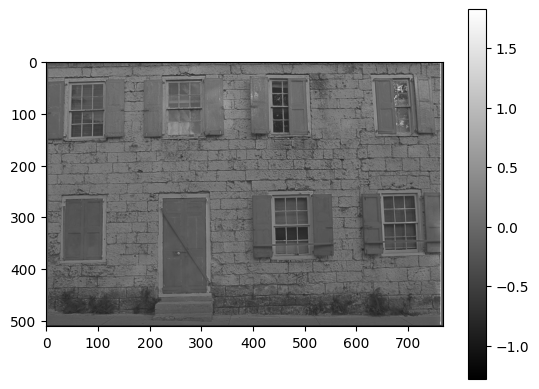

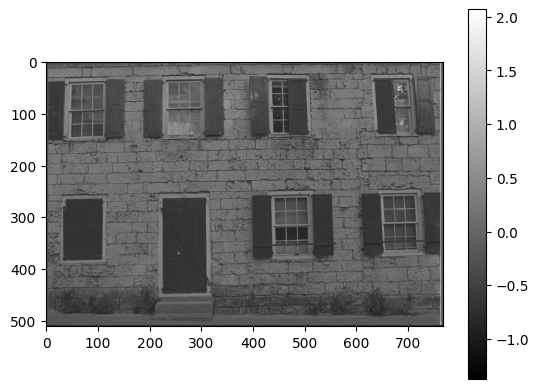

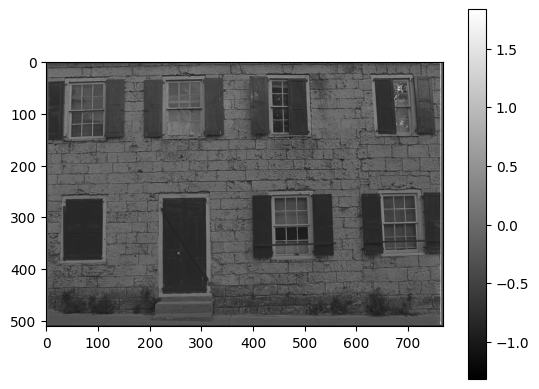

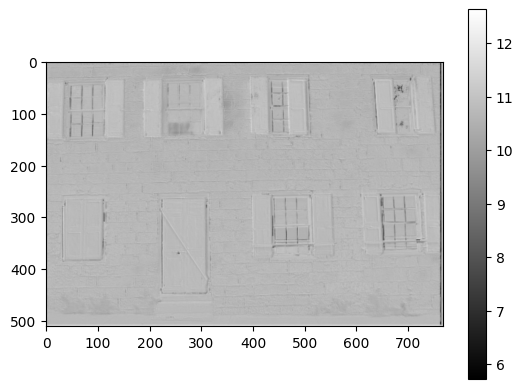

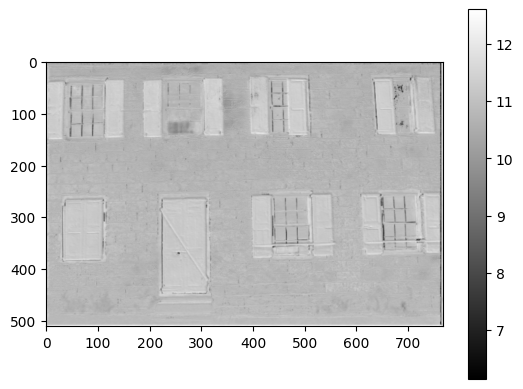

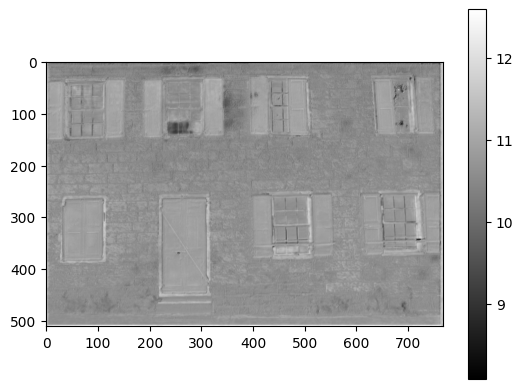

In [7]:
# 
print(random_prior["raw_out"].size())
print(random_prior["rate"].size())
# print(random_prior["additional_data"])
print(torch.min(random_prior["raw_out"]), torch.max(random_prior["raw_out"]))

for slice_index in range(6):
    image_tensor_2d = random_prior["raw_out"].cpu().numpy()[0, slice_index]
    plt.imshow(
        image_tensor_2d,
        cmap="gray",
    )
    plt.colorbar()
    plt.show()

In [8]:
coolchic.size_per_latent

[(1, 1, 512, 768),
 (1, 1, 256, 384),
 (1, 1, 128, 192),
 (1, 1, 64, 96),
 (1, 1, 32, 48),
 (1, 1, 16, 24),
 (1, 1, 8, 12)]

In [9]:
from lossless.util.encoding import encode

In [10]:
from lossless.util.distribution import modify_regular_prob, rans_freq_precision

def compute_logistic_cdfs(mu:torch.Tensor, scale:torch.Tensor, bitdepth:int)->torch.Tensor:
    '''
        function to calculate the cdfs of the Logistic(mu, scale) distribution
        used for encoder
    '''
    mu = mu
    scale = scale
    n,c,h,w=mu.shape
    max_v = float((1<<bitdepth)-1)
    size = 1 << bitdepth
    interval = 1. / max_v
    endpoints = torch.arange(-1.0+interval,1.0, 2*interval, device=mu.device).repeat((n,c,h,w,1)) # n c w h maxv
    mu = mu.unsqueeze(-1).repeat((1,1,1,1,size-1)) # n c w h maxv
    scale = scale.unsqueeze(-1).repeat((1,1,1,1,size-1)) # n c w h maxv
    invscale = 1. / scale
    endpoints_rescaled = (endpoints-mu)*invscale
    cdfs = torch.zeros(n,c,h,w,size+1, device=mu.device)
    cdfs[...,1:-1] = torch.sigmoid(endpoints_rescaled)
    cdfs[...,-1] = 1.0
    probs = cdfs[...,1:] - cdfs[...,:-1]
    probs = modify_regular_prob(probs)
    torch.use_deterministic_algorithms(False)
    cdfs[...,1:] = torch.cumsum(probs, dim=-1)
    torch.use_deterministic_algorithms(True)
    cdfs[...,-1] = 1.0
    cdfs_q = torch.round(cdfs * float(1<<rans_freq_precision)).to(torch.int16)
    return cdfs_q

def encode(x: torch.Tensor, mu: torch.Tensor, scale: torch.Tensor):
    x_maxv = (1 << 8) - 1
    # print(f"raw x: ",x.min(), x.max(), x.mean())
    x = torch.round(x_maxv * x).to(torch.int16).float() / x_maxv
    x_reshape = torch.round(x * ((1 << 8) - 1)).to(torch.int16).cpu()

    # plt.imshow(np.transpose(x_reshape[0].cpu().numpy(), (1, 2, 0)))
    # print(f"raw x_reshape: ",x_reshape.min(), x_reshape.max(), x_reshape.float().mean())
    byte_strings = []
    for i in range(3):
        symbols = x_reshape[:, i : i + 1, ...]
        print(
            f"Channel {i}: symbols shape {symbols.shape}, min {symbols.min()}, max {symbols.max()}"
        )
        cur_cdfs = compute_logistic_cdfs(
            mu[:, i : i + 1, ...], scale[:, i : i + 1, ...], 8
        ).cpu()
        # cur_cdfs_print_ver = torch.clone(cur_cdfs).to(torch.float)
        # cur_cdfs_print_ver[cur_cdfs_print_ver < 0] = cur_cdfs_print_ver[cur_cdfs_print_ver < 0] + 65536
        # cur_cdfs_print_ver /= 65536
        # print(f"cur_cdfs_print_ver: ",cur_cdfs_print_ver.min(), cur_cdfs_print_ver.max(), cur_cdfs_print_ver.float().mean())
        # print(f"cur_cdfs_print_ver shape: ",cur_cdfs_print_ver.shape)
        # print(cur_cdfs_print_ver[0,0,100,100], x[0,0,100,100])
        byte_strings.append(
            torchac.encode_int16_normalized_cdf(cur_cdfs, symbols)
        )
    return byte_strings


0.00804291 1.1920929e-07 0.97362894


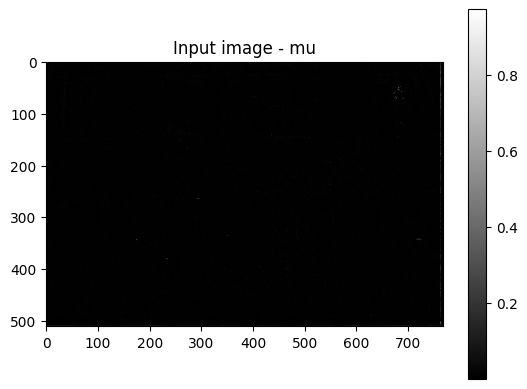

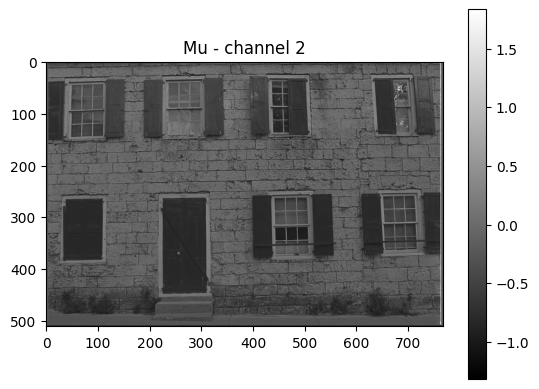

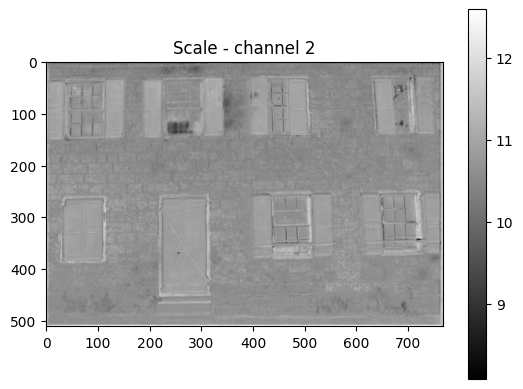

In [11]:
mu = random_prior["raw_out"][:, :3]
scale = random_prior["raw_out"][:, 3:6]
im_tensor_plottable = im_tensor[0].permute(1, 2, 0).cpu().numpy()
mu_plottable = mu[0].permute(1, 2, 0).cpu().numpy()
scale_plottable = scale[0].permute(1, 2, 0).cpu().numpy()

channel = 2
diff = im_tensor_plottable[:,:,channel]*2-1 - mu_plottable[:,:,channel]
diff = np.abs(diff)
print(np.mean(diff), np.min(diff), np.max(diff))
plt.imshow(diff, cmap='gray')
plt.title("Input image - mu")
plt.colorbar()
plt.show()
plt.imshow(mu_plottable[:,:,channel], cmap='gray')
plt.title("Mu - channel {}".format(channel))
plt.colorbar()
plt.show()
plt.imshow(scale_plottable[:,:,channel], cmap='gray')
plt.title("Scale - channel {}".format(channel))
plt.colorbar()
plt.show()

In [12]:
from lossless.util.distribution import get_scale

In [13]:
def get_bits_per_pixel(w, h, c, encoded_bytes):
    num_pixels = w * h * c
    num_bits = 0
    for bytes_channel in encoded_bytes:
        num_bits += len(bytes_channel) * 8
    return num_bits / num_pixels

scale_proper = get_scale(scale)
clamp_scale_to = 0.2
print(f"mu: {mu.min()} {mu.max()}, scale: {scale_proper.min()} {scale_proper.max()}")
encoded_bytes = encode(im_tensor,  mu, scale_proper)
print(get_bits_per_pixel(768, 512, 3, encoded_bytes))

mu: -1.3736447095870972 2.068918228149414, scale: 0.0018060008296743035 0.05714760720729828
Channel 0: symbols shape torch.Size([1, 1, 512, 768]), min 0, max 255
Channel 1: symbols shape torch.Size([1, 1, 512, 768]), min 0, max 255
Channel 2: symbols shape torch.Size([1, 1, 512, 768]), min 0, max 255
2.32171630859375


In [14]:
best_bpd = 2.8752034505208335
if get_bits_per_pixel(768, 512, 3, encoded_bytes) < best_bpd:
    best_bpd = get_bits_per_pixel(768, 512, 3, encoded_bytes)
    print(f"Best BPD: {best_bpd}")

Best BPD: 2.32171630859375


Decoded R: shape torch.Size([1, 1, 512, 768]), min 0, max 255
Decoded G: shape torch.Size([1, 1, 512, 768]), min 0, max 255
Decoded B: shape torch.Size([1, 1, 512, 768]), min 0, max 255
0.0 1.0


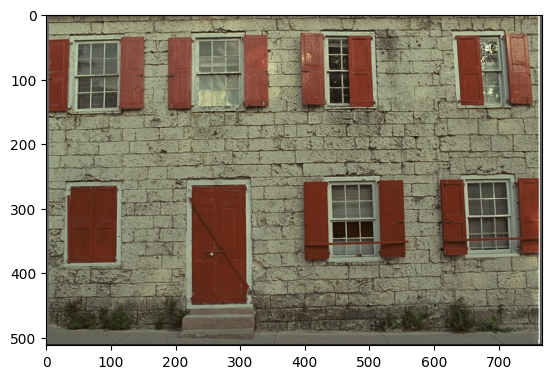

PNG bpd: 4.995 vs New lossless method: 2.322


In [15]:
decoded_im = decode(encoded_bytes, mu, get_scale(scale))
decoded_im = decoded_im.cpu().numpy()
print(np.min(decoded_im), np.max(decoded_im))

# decoded_im has shape torch.Size([1, 3, 512, 768])
# show it via plt

# decoded_im is a numpy array with shape (1, 3, 512, 768)
# To display as an image, we need shape (512, 768, 3)
plt.imshow(np.transpose(decoded_im[0], (1, 2, 0)))
plt.show()
assert np.allclose(decoded_im, im_tensor.cpu().numpy()), "Decoded image does not match original"
print(f"PNG bpd: {736501 / 768 / 512 / 3 * 8:.3f} vs New lossless method: {get_bits_per_pixel(768, 512, 3, encoded_bytes):.3f}")

In [16]:
# Let's verify the fix worked by checking reconstruction
print("🔍 VERIFYING LOSSLESS RECONSTRUCTION:")
print("-" * 40)

print(f"Original image shape: {im_tensor.shape}")
print(f"Original image range: [{im_tensor.min():.6f}, {im_tensor.max():.6f}]")

print(f"\nDecoded image shape: {decoded_im.shape}")
print(f"Decoded image range: [{decoded_im.min():.6f}, {decoded_im.max():.6f}]")

# Check if reconstruction is perfect (lossless)
reconstruction_error = np.abs(im_tensor.cpu().numpy() - decoded_im).max()
print(f"\nMax reconstruction error: {reconstruction_error:.10f}")

if reconstruction_error < 1e-6:
    print("✅ SUCCESS: Perfect lossless reconstruction!")
else:
    print(f"❌ ISSUE: Reconstruction error = {reconstruction_error}")
    
    # Let's check per channel
    for i in range(3):
        channel_error = np.abs(im_tensor[0, i].cpu().numpy() - decoded_im[0, i]).max()
        print(f"   Channel {i} error: {channel_error:.10f}")

# Check some statistics
print(f"\nChannel statistics:")
for i in range(3):
    orig_mean = im_tensor[0, i].mean().item()
    decoded_mean = decoded_im[0, i].mean()
    print(f"   Channel {i}: Original mean={orig_mean:.6f}, Decoded mean={decoded_mean:.6f}")

🔍 VERIFYING LOSSLESS RECONSTRUCTION:
----------------------------------------
Original image shape: torch.Size([1, 3, 512, 768])
Original image range: [0.000000, 1.000000]

Decoded image shape: (1, 3, 512, 768)
Decoded image range: [0.000000, 1.000000]

Max reconstruction error: 0.0000000000
✅ SUCCESS: Perfect lossless reconstruction!

Channel statistics:
   Channel 0: Original mean=0.469652, Decoded mean=0.469652
   Channel 1: Original mean=0.426456, Decoded mean=0.426456
   Channel 2: Original mean=0.346614, Decoded mean=0.346614


In [17]:
# Add this cell to your notebook to get the actual network rate
print("🔧 GETTING NETWORK RATE WITH QUANTIZATION ENABLED")
print("=" * 50)

coolchic.eval()
with torch.no_grad():
    # Enable quantization to get actual network bitrate
    quantized_output = coolchic.forward(
        quantizer_noise_type="none",
        quantizer_type="hardround", 
        AC_MAX_VAL=-1,  # Enable quantization (use max value)
        flag_additional_outputs=False,
    )

# Now get the network rate
nn_rate_per_module, total_nn_rate = coolchic.get_network_rate()

print("Network rate breakdown:")
for module_name, rates in nn_rate_per_module.items():
    weight_rate = rates.get("weight", 0)
    bias_rate = rates.get("bias", 0) 
    total_module_rate = weight_rate + bias_rate
    print(f"  {module_name}: {total_module_rate:.1f} bits (weights: {weight_rate:.1f}, bias: {bias_rate:.1f})")

print(f"\nTotal NN rate: {total_nn_rate:.1f} bits")

# Convert to bits per pixel
image_pixels = 768 * 512
nn_bpp = total_nn_rate / image_pixels
print(f"NN rate: {nn_bpp:.4f} bpp")

🔧 GETTING NETWORK RATE WITH QUANTIZATION ENABLED
Network rate breakdown:
  arm: 0.0 bits (weights: 0.0, bias: 0.0)
  upsampling: 0.0 bits (weights: 0.0, bias: 0.0)
  synthesis: 0.0 bits (weights: 0.0, bias: 0.0)

Total NN rate: 0.0 bits
NN rate: 0.0000 bpp


In [18]:
# from torch import Tensor, nn
# from enc.component.types import DescriptorNN
# from enc.nnquant.quantstep import get_q_step_from_parameter_name

# @torch.no_grad()
# def measure_expgolomb_rate(
#     q_module: nn.Module, q_step: DescriptorNN, expgol_cnt: DescriptorNN
# ) -> DescriptorNN:
#     """Get the rate associated with the current parameters.

#     Returns:
#         DescriptorNN: The rate of the different modules wrapped inside a dictionary
#             of float. It does **not** return tensor so no back propagation is possible
#     """
#     # Concatenate the sent parameters here to measure the entropy later
#     sent_param: DescriptorNN = {"bias": [], "weight": []}
#     rate_param: DescriptorNN = {"bias": 0.0, "weight": 0.0}

#     param = q_module.get_param()
#     # Retrieve all the sent item
#     for parameter_name, parameter_value in param.items():
#         current_q_step = get_q_step_from_parameter_name(parameter_name, q_step)
#         # Current quantization step is None because the module is not yet
#         # quantized. Return an all zero rate
#         if current_q_step is None:
#             print("returning")
#             return rate_param

#         # Quantization is round(parameter_value / q_step) * q_step so we divide by q_step
#         # to obtain the sent latent.
#         current_sent_param = (parameter_value / current_q_step).view(-1)

#         if ".weight" in parameter_name:
#             sent_param["weight"].append(current_sent_param)
#         elif ".bias" in parameter_name:
#             sent_param["bias"].append(current_sent_param)
#         else:
#             print(
#                 'Parameter name should include ".weight" or ".bias" '
#                 f"Found: {parameter_name}"
#             )
#             return rate_param

#     # For each sent parameters (e.g. all biases and all weights)
#     # compute their cost with an exp-golomb coding.
#     for k, v in sent_param.items():
#         # If we do not have any parameter, there is no rate associated.
#         # This can happens for the upsampling biases for instance
#         if len(v) == 0:
#             rate_param[k] = 0.0
#             continue

#         # Current exp-golomb count is None because the module is not yet
#         # quantized. Return an all zero rate
#         current_expgol_cnt = expgol_cnt[k]
#         if current_expgol_cnt is None:
#             return rate_param

#         # Concatenate the list of parameters as a big one dimensional tensor
#         v = torch.cat(v)

#         # This will be pretty long! Could it be vectorized?
#         rate_param[k] = exp_golomb_nbins(v, count=current_expgol_cnt)

#     return rate_param

# for module_name in coolchic.modules_to_send:
#     cur_module = getattr(coolchic, module_name)
#     print(measure_expgolomb_rate(
#         cur_module,
#         coolchic.nn_q_step.get(module_name),
#         coolchic.nn_expgol_cnt.get(module_name),
#     ))

In [19]:
# from enc.nnquant.quantizemodel import quantize_model

import itertools
import time
from typing import Optional, OrderedDict

from lossless.component.types import DescriptorNN
import torch
from lossless.nnquant.expgolomb import POSSIBLE_EXP_GOL_COUNT, exp_golomb_nbins
from lossless.nnquant.quantstep import (
    POSSIBLE_Q_STEP,
    get_q_step_from_parameter_name,
)
from lossless.training.loss import loss_function
from lossless.training.manager import FrameEncoderManager
from torch import Tensor


def _quantize_parameters(
    fp_param: OrderedDict[str, Tensor],
    q_step: DescriptorNN,
) -> Optional[OrderedDict[str, Tensor]]:
    """Quantize a dictionary of parameters fp_param with a given quantization
    step (e.g. one for bias one for the weight).
    Return None if quantization fails i.e. if round(param / q_step) is greater
    than MAC_AX_MAX_VAL.

    Args:
        fp_param (OrderedDict[str, Tensor]): Full precision parameter, usually
            the output of self.get_param() or self.named_parameters()
        q_step (DescriptorNN): A dictionary with one quantization step for the
            weight and one for the bias.

    Returns:
        Optional[OrderedDict[str, Tensor]]: The quantized parameters or None
            if quantization failed.
    """
    MAX_AC_MAX_VAL = 65535  # 2**16 for 16-bit code in bitstream header.

    q_param = OrderedDict()
    for k, v in fp_param.items():
        current_q_step = get_q_step_from_parameter_name(k, q_step)
        # supress type warning
        assert current_q_step is not None
        sent_param = torch.round(v / current_q_step)

        if sent_param.abs().max() > MAX_AC_MAX_VAL:
            return None

        q_param[k] = sent_param * current_q_step

    return q_param


@torch.no_grad()
def quantize_model(
    model: CoolChicEncoder,
    image: Tensor,
    frame_encoder_manager: FrameEncoderManager,
) -> CoolChicEncoder:
    """Quantize a ``FrameEncoder`` compressing a ``Frame`` under a rate
    constraint ``lmbda`` and return it.

    This function iterates on all the neural networks sent from the encoder
    to the decoder, listed in
    `frame_encoder.coolchic_enc["residue"].modules_to_send`.
    For each module :math:`m`, we want to find the most suited pair of
    quantization steps for the weight and the biases :math:`(\\Delta_w^m,
    \\Delta_b^m)`.

    To do so, a greedy search is used where we quantize the weights and biases
    using all the possible pairs of quantization steps, and we compute the
    :doc`usual loss function <./loss>`. The loss measures the impact of the NN
    quantization steps :math:`(\\Delta_w^m, \\Delta_b^m)` on the MSE / rate of
    the decoded image and the rate of the NN.-

    In the end, we select the pair of quantization step minimizing the loss:

        .. math::

            (\\Delta_w^m, \\Delta_b^m) = \\arg\\min ||\\mathbf{x}
            - \hat{\\mathbf{x}}||^2 + \\lambda
            (\\mathrm{R}(\hat{\\mathbf{x}}) + \\mathrm{R}_{NN}), \\text{ with }
            \\begin{cases}
                \\mathbf{x} & \\text{the original image}\\\\ \\hat{\\mathbf{x}} &
                \\text{the coded image}\\\\ \\mathrm{R}(\\hat{\\mathbf{x}}) &
                \\text{A measure of the rate of } \\hat{\\mathbf{x}} \\\\
                    \\mathrm{R}_{NN} & \\text{The rate of the neural networks}
            \\end{cases}

    Then we quantize the next module to be sent.

    .. warning::

        The parameter ``frame_encoder_manager`` tracking the encoding time of
        the frame (``total_training_time_sec``) and the number of encoding
        iterations (``iterations_counter``) is modified ** in place** by this
        function.


    Args:
        frame_encoder: Model to be compressed.
        frame: Original frame to code, including its references.
        frame_encoder_manager: Contains (among other things) the rate
            constraint :math:`\\lambda` and description of the warm-up preset.
            It is also used to track the total encoding time and encoding
            iterations. Modified in place.

    Returns:
        Model with quantized parameters.
    """
    start_time = time.time()
    model.eval()

    # We have to quantize all the modules that we want to send
    module_to_quantize = {
        module_name: getattr(model, module_name)
        for module_name in model.modules_to_send
    }

    for module_name, cur_module in sorted(module_to_quantize.items()):
        # Start the RD optimization for the quantization step of each module with an
        # arbitrary high value for the RD cost.
        best_loss = 1e6

        # All possible quantization steps for this module
        all_q_step = POSSIBLE_Q_STEP.get(module_name)
        all_expgol_cnt = POSSIBLE_EXP_GOL_COUNT.get(module_name)
        assert all_q_step is not None
        assert all_expgol_cnt is not None

        # Save full precision parameter.
        fp_param = cur_module.get_param()

        best_q_step = {}
        # Overall best expgol count for this module weights and biases
        final_best_expgol_cnt = {}
        all_q_step_weight = all_q_step.get("weight")
        all_q_step_bias = all_q_step.get("bias")
        assert all_q_step_weight is not None
        assert all_q_step_bias is not None
        
        for q_step_w, q_step_b in itertools.product(
            all_q_step_weight, all_q_step_bias
        ):
            # Reset full precision parameters, set the quantization step
            # and quantize the model.
            current_q_step: DescriptorNN = {
                "weight": q_step_w,
                "bias": q_step_b,
            }

            # Reset full precision parameter before quantizing
            q_param = _quantize_parameters(fp_param, current_q_step)

            # Quantization has failed
            if q_param is None:
                continue

            cur_module.set_param(q_param)

            # Plug the quantized module back into Cool-chic
            # setattr(frame_encoder.coolchic_enc[cc_name], module_name, cur_module)
            setattr(model, module_name, cur_module)

            model.nn_q_step[module_name] = current_q_step

            # Test Cool-chic performance with this quantization steps pair
            frame_encoder_out = model.forward(
                quantizer_noise_type="none",
                quantizer_type="hardround",
                AC_MAX_VAL=-1,
                flag_additional_outputs=False,
            )

            param = cur_module.get_param()

            # Best exp-golomb count for this quantization step
            best_expgol_cnt = {}
            for weight_or_bias in ["weight", "bias"]:

                # Find the best exp-golomb count for this quantization step:
                cur_best_expgol_cnt = None
                # Arbitrarily high number
                cur_best_rate = 1e9

                sent_param = []
                for parameter_name, parameter_value in param.items():

                    # Quantization is round(parameter_value / q_step) * q_step so we divide by q_step
                    # to obtain the sent latent.
                    current_sent_param = (
                        parameter_value / current_q_step[weight_or_bias]
                    ).view(-1)

                    if weight_or_bias in parameter_name:
                        sent_param.append(current_sent_param)

                # Integer, sent parameters
                v = torch.cat(sent_param)

                # Find the best expgol count for this weight
                for expgol_cnt in all_expgol_cnt[weight_or_bias]:
                    cur_rate = exp_golomb_nbins(v, count=expgol_cnt)
                    if cur_rate < cur_best_rate:
                        cur_best_rate = cur_rate
                        cur_best_expgol_cnt = expgol_cnt

                best_expgol_cnt[weight_or_bias] = int(cur_best_expgol_cnt)

            model.nn_expgol_cnt[module_name] = best_expgol_cnt

            _, total_rate_nn_bit = model.get_network_rate()

            # rate_mlp = 0.0
            # rate_per_module = cc_enc.get_network_rate()
            # for _, module_rate in rate_per_module.items():
            #     for _, param_rate in module_rate.items():  # weight, bias
            #         rate_mlp += param_rate

            loss_fn_output = loss_function(
                frame_encoder_out,
                image,
                rate_mlp_bpd=total_rate_nn_bit,
                latent_multiplier=1.0
            )

            # Store best quantization steps
            if loss_fn_output.loss < best_loss:
                best_loss = loss_fn_output.loss
                best_q_step = current_q_step
                final_best_expgol_cnt = best_expgol_cnt

        # Once we've tested all the possible quantization step and expgol_cnt,
        # quantize one last time with the best one we've found to actually use it.
        model.nn_q_step[module_name] = best_q_step
        model.nn_expgol_cnt[module_name] = final_best_expgol_cnt

        q_param = _quantize_parameters(fp_param, model.nn_q_step[module_name])
        assert q_param is not None, (
            "_quantize_parameters() failed with q_step "
            f"{model.nn_q_step[module_name]}"
        )

        cur_module.set_param(q_param)
        # Plug the quantized module back into Cool-chic
        setattr(model, module_name, cur_module)

    time_nn_quantization = time.time() - start_time

    print(f"\nTime quantize_model(): {time_nn_quantization:4.1f} seconds\n")
    frame_encoder_manager.total_training_time_sec += time_nn_quantization

    return model

In [20]:
coolchic._store_full_precision_param()
quantized_coolchic = quantize_model(coolchic, im_tensor, frame_encoder_manager)




Time quantize_model(): 11.3 seconds



In [21]:
rate_per_module, total_rate = quantized_coolchic.get_network_rate()
print(rate_per_module)

{'arm': {'bias': tensor(47., device='cuda:0'), 'weight': tensor(290., device='cuda:0')}, 'upsampling': {'bias': tensor(12., device='cuda:0'), 'weight': tensor(54., device='cuda:0')}, 'synthesis': {'bias': tensor(59., device='cuda:0'), 'weight': tensor(1352., device='cuda:0')}}


In [22]:
print(total_rate / im_tensor.numel())  # bpp

tensor(0.0015, device='cuda:0')


In [23]:
quantized_coolchic.latent_grids
# coolchic.size_per_latent

ParameterList(
    (0): Parameter containing: [torch.float32 of size 1x1x512x768 (cuda:0)]
    (1): Parameter containing: [torch.float32 of size 1x1x256x384 (cuda:0)]
    (2): Parameter containing: [torch.float32 of size 1x1x128x192 (cuda:0)]
    (3): Parameter containing: [torch.float32 of size 1x1x64x96 (cuda:0)]
    (4): Parameter containing: [torch.float32 of size 1x1x32x48 (cuda:0)]
    (5): Parameter containing: [torch.float32 of size 1x1x16x24 (cuda:0)]
    (6): Parameter containing: [torch.float32 of size 1x1x8x12 (cuda:0)]
)

In [24]:
coolchic.size_per_latent

[(1, 1, 512, 768),
 (1, 1, 256, 384),
 (1, 1, 128, 192),
 (1, 1, 64, 96),
 (1, 1, 32, 48),
 (1, 1, 16, 24),
 (1, 1, 8, 12)]

In [28]:
coolchic._load_full_precision_param()

In [29]:
with torch.no_grad():
    # Forward pass with no quantization noise
    # This is a random prior, i.e. the output is not conditioned on any input
    # image.
    random_prior_check = coolchic.forward(
        quantizer_noise_type="none",
        quantizer_type="hardround",
        AC_MAX_VAL=-1,
        flag_additional_outputs=False,
    )
print(f"Random prior: {random_prior_check.keys()}")

mu_check = random_prior_check["raw_out"][:, :3]
scale_check = random_prior_check["raw_out"][:, 3:6]
scale_proper_check = get_scale(scale_check)
clamp_scale_to = 0.2
print(f"mu: {mu_check.min()} {mu_check.max()}, scale: {scale_proper_check.min()} {scale_proper_check.max()}")
encoded_bytes_check = encode(im_tensor,  mu_check, scale_proper_check)
print(get_bits_per_pixel(768, 512, 3, encoded_bytes_check))

Random prior: dict_keys(['raw_out', 'rate', 'latent_bpd', 'additional_data'])
mu: -1.373652458190918 2.0689167976379395, scale: 0.0018061541486531496 0.05714365467429161
Channel 0: symbols shape torch.Size([1, 1, 512, 768]), min 0, max 255
Channel 1: symbols shape torch.Size([1, 1, 512, 768]), min 0, max 255
Channel 2: symbols shape torch.Size([1, 1, 512, 768]), min 0, max 255
2.3217298719618054


0.008043074 1.1920929e-07 0.9735809


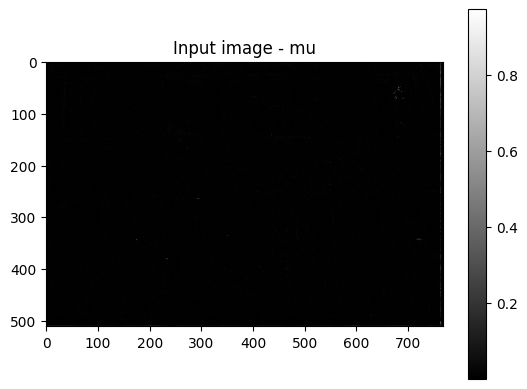

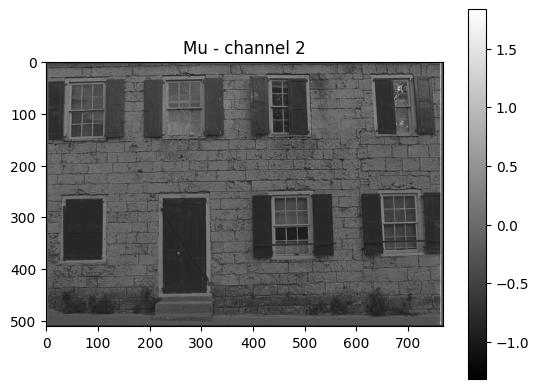

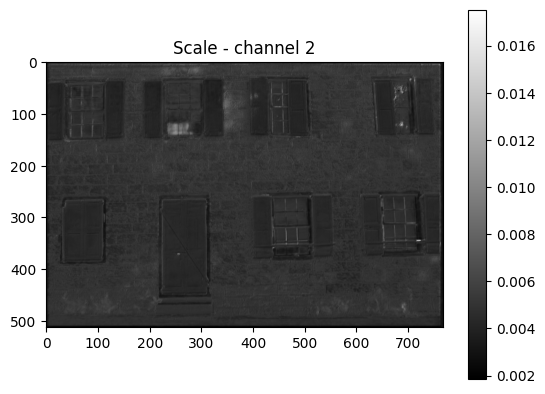

In [30]:
im_tensor_plottable = im_tensor[0].permute(1, 2, 0).cpu().numpy()
mu_plottable = mu_check[0].permute(1, 2, 0).cpu().numpy()
scale_plottable = scale_proper_check[0].permute(1, 2, 0).cpu().numpy()

channel = 2
diff = im_tensor_plottable[:,:,channel]*2-1 - mu_plottable[:,:,channel]
diff = np.abs(diff)
print(np.mean(diff), np.min(diff), np.max(diff))
plt.imshow(diff, cmap='gray')
plt.title("Input image - mu")
plt.colorbar()
plt.show()
plt.imshow(mu_plottable[:,:,channel], cmap='gray')
plt.title("Mu - channel {}".format(channel))
plt.colorbar()
plt.show()
plt.imshow(scale_plottable[:,:,channel], cmap='gray')
plt.title("Scale - channel {}".format(channel))
plt.colorbar()
plt.show()

In [ ]:
# save coolchic to file 0000_trained_model.
torch.save(coolchic.state_dict(), f"{TEST_WORKDIR}/0000_trained_coolchic_img_rate_{get_bits_per_pixel(768, 512, 3, encoded_bytes_check)}.pth")